In [56]:
import numpy as np
# import scanpy.api as sc
import pandas as pd
import pylab
import matplotlib.pyplot as plt
from collections import Counter
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import os
# import gseapy

from ete3 import Tree
import networkx as nx

import pickle as pic

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.stats.multitest as multi

import scipy.stats as scs

from tqdm import tqdm_notebook
from tqdm import tqdm

import utilities.metastasis_score_utils as met_utils
from cassiopeia.TreeSolver import data_pipeline
from cassiopeia.TreeSolver.Cassiopeia_Tree import Cassiopeia_Tree
import cassiopeia.TreeSolver.post_process_tree as ppt

#from fitch_parsimony import *

#from Cassiopeia.TreeSolver import data_pipeline


In [58]:
#dfAT = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/ALL.5k.FINISHED.alleleTable.txt", sep='\t')
#meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col = 0)
dfAT = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/100k/ALL.100k_20191113.large.alleleTable.txt", sep='\t')
meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/100k/100k_meta.txt", sep='\t', index_col = 0)

## Compute basic statistics

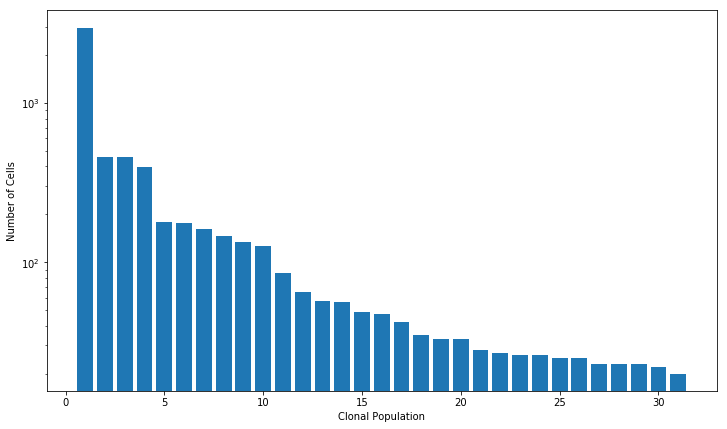

{1: 2981,
 2: 457,
 3: 456,
 4: 397,
 5: 179,
 6: 177,
 7: 162,
 8: 147,
 9: 135,
 10: 126,
 11: 85,
 12: 65,
 13: 57,
 14: 56,
 15: 49,
 16: 47,
 17: 42,
 18: 35,
 19: 33,
 20: 33,
 21: 28,
 22: 27,
 23: 26,
 24: 26,
 25: 25,
 26: 25,
 27: 23,
 28: 23,
 29: 23,
 30: 22,
 31: 20}

In [59]:
lg_sizes = dfAT.groupby("LineageGroup").agg({"cellBC": 'nunique'})

h = plt.figure(figsize=(12,7))
plt.bar(lg_sizes.index, lg_sizes['cellBC'])
plt.yscale('log')
plt.xlabel("Clonal Population")
plt.ylabel("Number of Cells")
#plt.savefig('figs/10k_lg_sizes.png')
plt.show()

lg_sizes = lg_sizes['cellBC'].to_dict()
lg_sizes

<Figure size 504x1080 with 0 Axes>

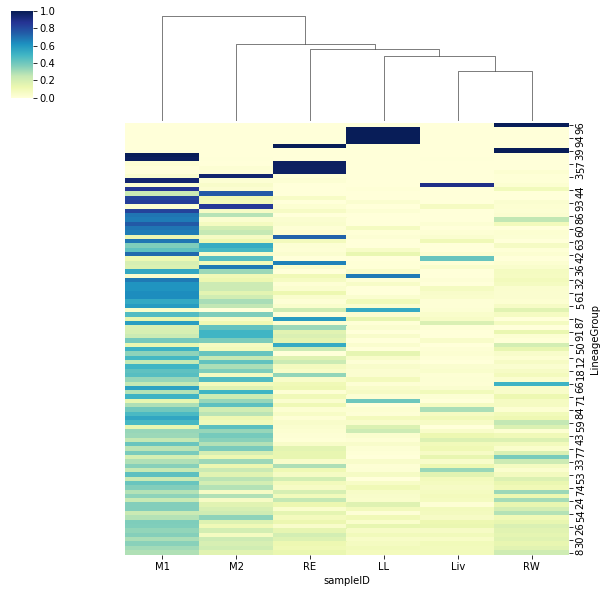

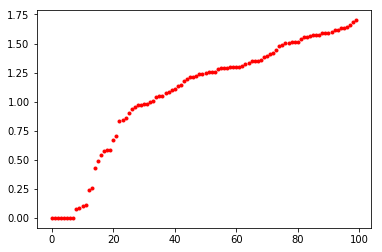

In [9]:
meta['BC'] = meta.index
samp_piv = pd.pivot_table(meta, index='LineageGroup', columns = 'sampleID', values = 'BC', aggfunc='count')

samp_piv.fillna(0, inplace=True)
samp_piv = samp_piv.apply(lambda x: x / x.sum(), axis=1)

entropy = samp_piv.apply(lambda x: -1*np.sum([p * np.log(p) for p in x.values if p > 0]), axis=1)
inds_order = entropy.sort_values().index

h = plt.figure(figsize = (7,15))
sns.clustermap(samp_piv.loc[inds_order], row_cluster=False, cmap='YlGnBu')
# plt.savefig("figs/lg_sample_dist.png")
plt.show()

plt.plot(range(100), entropy.sort_values(), 'r.')
plt.savefig("figs/10k_lg_entropy.png")
plt.show()

In [65]:
samp_piv.loc[samp_piv['LL'] == 1]

sampleID,LL,Liv,M1,M2,RE,RW
LineageGroup,,,,,,
29,1.0,0.0,0.0,0.0,0.0,0.0
46,1.0,0.0,0.0,0.0,0.0,0.0
78,1.0,0.0,0.0,0.0,0.0,0.0
94,1.0,0.0,0.0,0.0,0.0,0.0


## First perform filtering

In [60]:

dfAT_rtot = dfAT.groupby(["cellBC","LineageGroup"]).agg({"r1.old":'count'}).rename(index=str, columns={'r1.old':'r.tot'})
dfAT_r1unc = dfAT[dfAT['r1.old'].str.contains("None")].groupby(["cellBC","LineageGroup"]).agg({"r1.old":'count'}).rename(index=str, columns={'r1.old':'r1.uncut'})
dfAT_r2unc = dfAT[dfAT['r2.old'].str.contains("None")].groupby(["cellBC","LineageGroup"]).agg({"r2.old":'count'}).rename(index=str, columns={'r2.old':'r2.uncut'})
dfAT_r3unc = dfAT[dfAT['r3.old'].str.contains("None")].groupby(["cellBC","LineageGroup"]).agg({"r3.old":'count'}).rename(index=str, columns={'r3.old':'r3.uncut'})

dfCUT = pd.concat([dfAT_rtot,dfAT_r1unc,dfAT_r2unc,dfAT_r3unc], axis=1)
dfCUT = dfCUT.fillna(0)
dfCUT = dfCUT.sort_values("LineageGroup")

dfCUT['r1.cut%'] = 1-(dfCUT['r1.uncut']/dfCUT['r.tot'])
dfCUT['r2.cut%'] = 1-(dfCUT['r2.uncut']/dfCUT['r.tot'])
dfCUT['r3.cut%'] = 1-(dfCUT['r3.uncut']/dfCUT['r.tot'])

dfCUT['cut%'] = (dfCUT['r1.cut%']+dfCUT['r2.cut%']+dfCUT['r3.cut%'])/3

X1 = dfCUT.groupby(['LineageGroup']).agg({'r1.cut%':'mean'})
X2 = dfCUT.groupby(['LineageGroup']).agg({'r2.cut%':'mean'})
X3 = dfCUT.groupby(['LineageGroup']).agg({'r3.cut%':'mean'})

XCUT = pd.concat([X1,X2,X3], axis=1).reset_index()
XCUT.LineageGroup = pd.to_numeric(XCUT.LineageGroup, errors='coerce')
XCUT = XCUT.sort_values("LineageGroup").set_index("LineageGroup")

cut_rates = XCUT.sum(1)/3

# cut_rates.to_csv("data/cutRateByLG.10k.txt", sep='\t')

In [61]:
# cut_rates = pd.read_csv("data/cutRateByLG.5k.txt", sep='\t', header=None, index_col = 0)

labels = []
tree_fps = []
lg_to_tree = {}
lg_to_cm = {}
i = 0
for tree_dir in tqdm_notebook(os.listdir("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/")):
    tree_dir = "/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/" + tree_dir + "/"
    if not os.path.isdir(tree_dir):
        continue
    
    lg = tree_dir.split("/")[-2][2:]
    #fps = [fp for fp in os.listdir(tree_dir) if ".txt" in fp and 'tree' in fp and 'nj' not in fp and 'processed' not in fp]
    fps = [fp for fp in os.listdir(tree_dir) if "alleleThresh.processed.pkl" in fp and 'nj' not in fp]
    cmfp = [fp for fp in os.listdir(tree_dir) if "_character_matrix.alleleThresh.txt" in fp]
    if len(fps) > 0:
            try:
                tree = nx.read_gpickle(tree_dir + fps[0])
                lg_to_tree[int(lg)] = tree
                tree_fps.append(tree_dir + fps[0])
                cmfp = tree_dir + cmfp[0]
                labels.append(int(lg))
                cm = pd.read_csv(cmfp, sep='\t', index_col = 0, dtype=str)
                lg_to_cm[int(lg)] = cm
            except:
                print(lg)
                i += 1
            #tree = Cassiopeia_Tree('from_newick', network = data_pipeline.newick_to_network(tree_dir + fps[0], cm))
            #lg_to_tree[int(lg)] = tree.post_process(cm)
print(i)    


0


In [62]:
complexities = []
crs = []
num_leaves = []
num_nodes = []
uniq_states = []
for lg in tqdm_notebook(lg_to_tree.keys()):
    
    crs.append(cut_rates.loc[lg])
    tree_complexity = met_utils.compute_tree_complexity(lg_to_tree[lg].network)
    complexities.append(tree_complexity[0])
    num_leaves.append(tree_complexity[1])
    num_nodes.append(tree_complexity[2])
    uniq_states.append(lg_to_cm[lg].drop_duplicates().shape[0] / lg_to_cm[lg].shape[0])

    
tree_stats = pd.DataFrame(index = lg_to_tree.keys(), columns = ["CutRate", "TreeComplexity"])
tree_stats["CutRate"] = crs
tree_stats["TreeComplexity"] = complexities
tree_stats["NumLeaves"] = num_leaves
tree_stats["NumNodes"] = num_nodes
tree_stats['UniqStates'] = uniq_states

h = plt.figure(figsize=(7,7))
plt.plot(tree_stats["CutRate"], tree_stats["UniqStates"], '.')
plt.axvline(x = 0.15, color="red", linestyle="dashed")
plt.axhline(y = 0.667, color="black", linestyle="dashed")
plt.xlabel("Cutting Rate")
plt.ylabel("Percent Unique States")
plt.title("Tree Filtering Decision Rule")

for i in tree_stats.index:
    plt.annotate(i, (tree_stats.loc[i, "CutRate"]+0.01, tree_stats.loc[i, "UniqStates"] + 0.01))

# plt.savefig("figs/filter_clones.png")
plt.show()

# plt.plot(tree_stats["NumLeaves"], tree_stats["NumNodes"], ".")
# plt.title("Leaves vs Nodes")
# plt.xlabel("Number of Leaves")
# plt.ylabel("Number of Nodes")
# plt.plot(tree_stats["NumLeaves"], tree_stats["NumLeaves"], color = "red", linestyle="dashed")
# plt.plot(tree_stats["NumLeaves"], 2*tree_stats["NumLeaves"], color = "red", linestyle="dashed")
# plt.loglog()
# plt.show()


to_drop = list(tree_stats[(tree_stats["CutRate"] < 0.15)].index)
to_drop += list(tree_stats[tree_stats["UniqStates"] < 0.667].index)

print(set(to_drop), len(set(to_drop)))

KeyError: 57

/data/yosef2/users/mattjones/projects/metastasis/MetastasisTracing/utilities/metastasis_score_utils.py:78: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  table = pd.concat([background, query], axis=1)


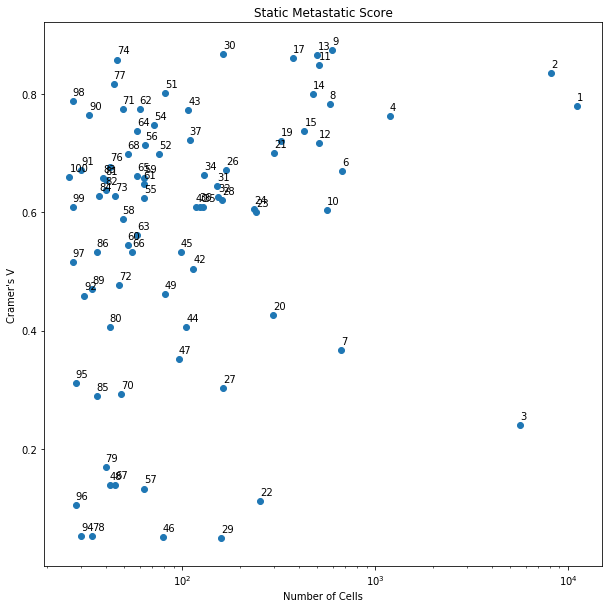

In [22]:
background = {}
for n, g in meta.groupby("sampleID"):
    background[n] = g.shape[0]
    
background = pd.DataFrame.from_dict(background, orient="index")

static_stats = {}
for n, g in tqdm_notebook(meta.groupby(["LineageGroup"])):

    if n in to_drop:
        continue
    
    stats = met_utils.compute_static_metastasis_score(g, background,  group_var = 'sampleID')
    
    static_stats[n] = tuple(stats)
    
colormap = ["blue"] * len(static_stats)
# colormap[0] = "red"
# colormap[1] = "green"
# colormap[3] = "black"
# colormap[5] = 'orange'
# colormap[35] = "black"

sizes = dict(zip(static_stats.keys(), list(map(lambda x: x[0], static_stats.values()))))
ss = dict(zip(static_stats.keys(), list(map(lambda x: 1 - x[3], static_stats.values()))))
labs = static_stats.keys()
# labs = [0, 1, 3, 5, 35]

h = plt.figure(figsize = (10, 10))
plt.scatter(sizes.values(), ss.values())
plt.xscale('log')
plt.xlabel("Number of Cells")
plt.ylabel("Cramer's V")
plt.title("Static Metastatic Score")

for i in labs:
   plt.annotate(i, (sizes[i]+0.05, ss[i]+0.01))

# plt.savefig("figs/static_met_score.pdf")
plt.show()

## Compute the dynamic metastatic score

In [23]:
evolving_scores = {}
nn_scores = {}
lg_to_fitch = {}
# met_scores = pd.read_csv("data/lg_metastatic_scores.txt", sep='\t', index_col = 0)

for n in tqdm_notebook(labels):

    if n not in to_drop:
        #if n not in met_scores.index:
        tree = lg_to_tree[n].network
        evolving_scores[n] = met_utils.compute_dynamic_metastasis_score(tree, meta['sampleID'])
        nn_scores[n] = met_utils.compute_NN_metastasis_score(tree, meta['sampleID'], _method = 'allele', verbose=False)
#         else:
#             evolving_scores[n] = met_scores.loc[n, 'Dynamic']
#             nn_scores[n] = met_scores.loc[n, 'NearestNeighbor']

    
    

Creating pairs to compare: 100%|██████████| 34/34 [00:00<00:00, 61601.01it/s]

[18, 50, 5, 75, 16, 87, 69, 25, 18, 33, 39, 88, 53, 38, 93, 25, 41]


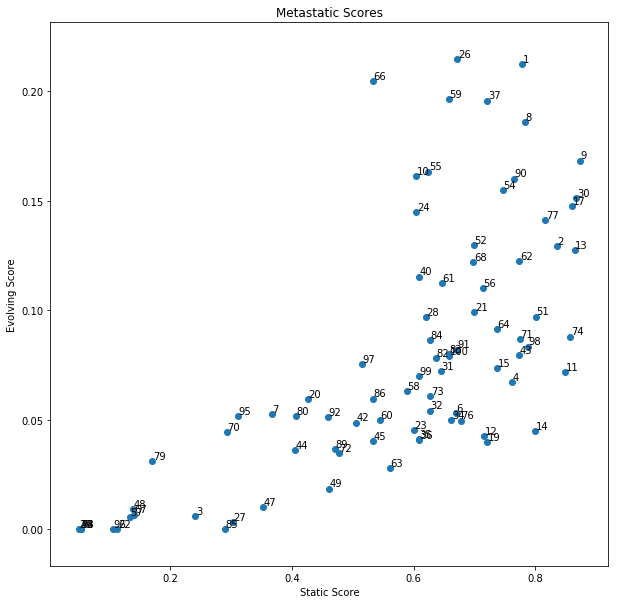

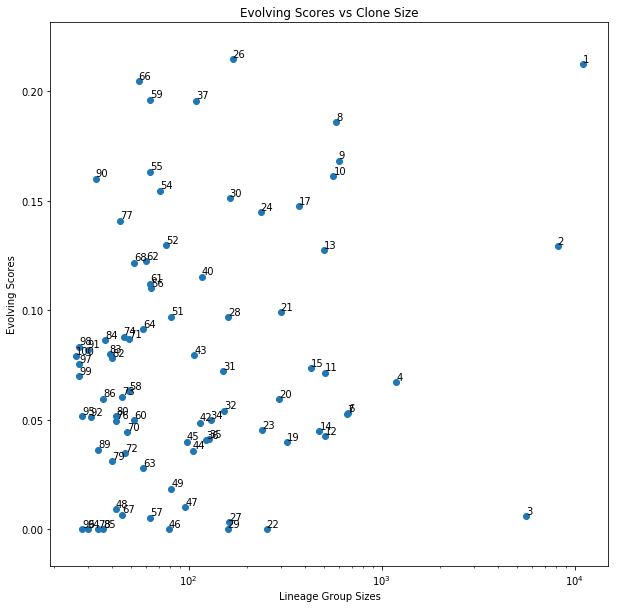

In [24]:
subset_static_scores = {}
for k in evolving_scores.keys():
    subset_static_scores[k] = static_stats[k]
    
ss = list(map(lambda x: 1 - x[3], subset_static_scores.values()))
sizes = list(map(lambda x: x[0], subset_static_scores.values()))
es = list(evolving_scores.values())
#labs = [2, 3, 4, 5, 6, 10, 12, 16, 21, 35, 39, 40, 52, 77, 84]
    
h = plt.figure(figsize = (10, 10))
plt.scatter(ss, es)
plt.xlabel("Static Score")
plt.ylabel("Evolving Score")
plt.title("Metastatic Scores")

for i, txt in enumerate(subset_static_scores.keys()):
    plt.annotate(txt, (ss[i]+0.001, es[i]+0.001))
    
# plt.savefig("figs/10k_static_vs_evolving.pdf")


h = plt.figure(figsize = (10, 10))
plt.scatter(sizes, es)
plt.xscale('log')
plt.xlabel("Lineage Group Sizes")
plt.ylabel("Evolving Scores")
plt.title("Evolving Scores vs Clone Size")

for i, txt in enumerate(subset_static_scores.keys()):
    plt.annotate(txt, (sizes[i]+0.001, es[i]+0.001))
    
# plt.savefig("figs/10k_dynamic_met_scores.pdf")

print(to_drop)

In [79]:
print(len(nn_scores.keys()))

12


[18, 50, 5, 75, 16, 87, 69, 25, 18, 33, 39, 88, 53, 38, 93, 25, 41]


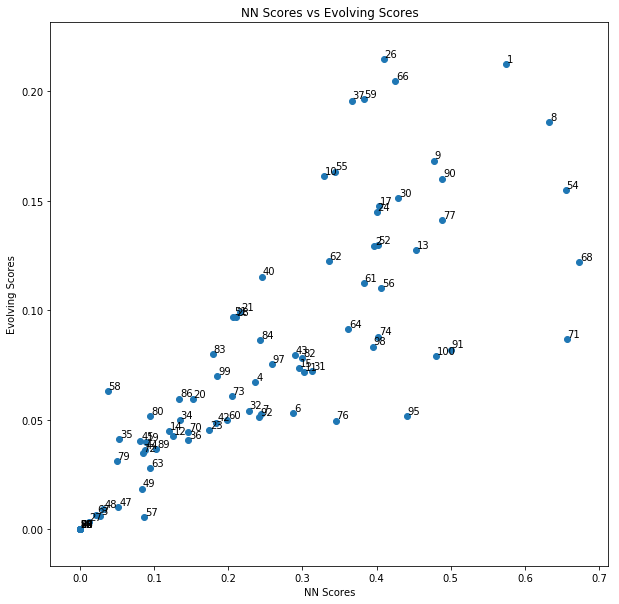

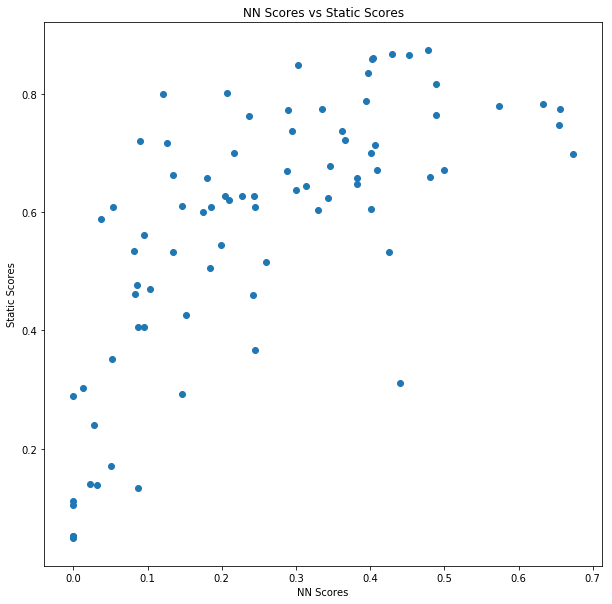

In [25]:
subset_evolving_scores = {}
subset_static_scores = {}
for k in nn_scores.keys():
    subset_evolving_scores[k] = evolving_scores[k]
    subset_static_scores[k] = static_stats[k]

ns = list(nn_scores.values())
es2 = list(subset_evolving_scores.values())
ss2 = list(map(lambda x: 1 - x[3], subset_static_scores.values()))
#labs = [2, 3, 4, 5, 6, 10, 12, 16, 21, 35, 39, 40, 52, 77, 84]
    

h = plt.figure(figsize = (10, 10))
plt.scatter(ns, es2)
plt.xlabel("NN Scores")
plt.ylabel("Evolving Scores")
plt.title("NN Scores vs Evolving Scores")

for i, txt in enumerate(subset_evolving_scores.keys()):
    plt.annotate(txt, (ns[i]+0.001, es2[i]+0.001))
    
# plt.savefig("figs/10k_nn_vs_evolvscores.pdf")

h = plt.figure(figsize = (10, 10))
plt.scatter(ns, ss2)
plt.xlabel("NN Scores")
plt.ylabel("Static Scores")
plt.title("NN Scores vs Static Scores")

# plt.savefig("figs/10k_nn_vs_staticscores.pdf")


print(to_drop)

In [26]:
met_scores = pd.DataFrame([ss, es]).T
met_scores.index = evolving_scores.keys()
met_scores.columns = ["Static", "Dynamic"]
met_scores['NearestNeighbor'] = met_scores.apply(lambda x: nn_scores[x.name] if x.name in nn_scores.keys() else None, axis=1)

met_scores.to_csv("data/lg_metastatic_scoresAllele.5k.txt", sep='\t')

## Compute Dynamic Metastatic Scores Across Tree

In [44]:
cells_to_dynmet = {}

for n in tqdm(labels):
    
    if n not in to_drop:

        lg = lg_to_tree[n].network
        root = [n for n in lg if lg.in_degree(n) == 0][0]

        for n in nx.dfs_postorder_nodes(lg, source=root):

            succ = [k for k in nx.descendants(lg, n)] + [n]
            if len(succ) == 1:
                continue

            subg = lg.subgraph(succ)

            lg.nodes[n]['DynMet'] = met_utils.compute_dynamic_metastasis_score(subg, meta['sampleID'])

        leaves = [n for n in lg if lg.out_degree(n) == 0]
        for l in leaves:

            path = nx.shortest_path(lg, root, l)
            ms = 0
            for p in path:
                if p != l:
                    ms += lg.nodes[p]['DynMet'] 
            ms /= (len(path) - 1)
            cells_to_dynmet[l.name] = ms
        

100%|██████████| 98/98 [03:27<00:00,  1.44it/s]


In [51]:
dynmetdf = pd.DataFrame.from_dict(cells_to_dynmet, orient='index')
meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col=0)

meta['StaticMetScore'] = np.nan
meta['TreeDynamicMetScore'] = np.nan
meta['DynamicMetScore'] = np.nan

for n in labels:
    if n not in to_drop:
        
        meta.loc[(meta['LineageGroup'] == n), 'TreeDynamicMetScore'] = met_scores.loc[n, 'Dynamic']
        meta.loc[(meta['LineageGroup'] == n), 'StaticMetScore'] = met_scores.loc[n, 'Static']
    
for k in tqdm(cells_to_dynmet):
    meta.loc[k, 'DynamicMetScore'] = cells_to_dynmet[k]
    
meta.head(5)

100%|██████████| 37887/37887 [00:20<00:00, 1804.22it/s]


,LineageGroup,sampleID,TS_UMI,NUM_INTBC,Sample2,StaticMetScore,DynamicMetScore,TreeDynamicMetScore
cellBC,,,,,,,,
RW.TTTGTCATCAGCTCGG-1,24,RW,44,6,RL,0.604708,0.215127,0.144817
RW.TTTGTCAGTTAGAACA-1,39,RW,186,5,RL,NaN,NaN,NaN
RW.TTTGTCAGTGTTTGTG-1,2,RW,158,4,RL,0.835465,0.141550,0.129337
RW.TTTGTCAGTGACGCCT-1,2,RW,195,10,RL,0.835465,0.080327,0.129337
RW.TTTGTCAGTACCGTTA-1,92,RW,166,7,RL,0.459287,0.012755,0.051020


In [52]:
meta.to_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t')

## Score alternative solutions

In [3]:
met_scores = pd.read_csv("data/lg_metastatic_scoresAllele.txt", sep='\t', index_col = 0)

lg_to_tree = {}
tree_fps =[]
labels = []
lg_to_cm = {}
i = 0
for tree_dir in tqdm(os.listdir("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/")):
    tree_dir = "/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/" + tree_dir + "/"
    if not os.path.isdir(tree_dir):
        continue
    
    lg = tree_dir.split("/")[-2][2:]
    #fps = [fp for fp in os.listdir(tree_dir) if ".txt" in fp and 'tree' in fp and 'nj' not in fp and 'processed' not in fp]
    fps = [fp for fp in os.listdir(tree_dir) if "alleleThresh.pkl" in fp and 'tree' in fp and 'nj' not in fp]
    cmfp = [fp for fp in os.listdir(tree_dir) if "_character_matrix.alleleThresh.txt" in fp]
    if len(fps) > 0:
            try:
                tree = pic.load(open(tree_dir + fps[0], 'rb'))
                lg_to_tree[int(lg)] = tree
                tree_fps.append(tree_dir + fps[0])
                cmfp = tree_dir + cmfp[0]
                labels.append(int(lg))
                cm = pd.read_csv(cmfp, sep='\t', index_col = 0, dtype=str)
                lg_to_cm[int(lg)] = cm
            except:
                print(lg)
                i += 1

                

100%|██████████| 113/113 [01:22<00:00,  1.37it/s]


In [4]:
for m in tqdm(met_scores.index):
    
    if m == 5:
        continue 
        
    lg = lg_to_tree[m]
    cm = lg_to_cm[m]
    
    alts = []
    for alt in lg.alternative_solutions:
        try:
            a = Cassiopeia_Tree('hybrid', network = alt)
            pp = a.post_process(cm).network

            alts.append(met_utils.compute_dynamic_metastasis_score(pp, meta['sampleID']))
        except:
            print(m)
            continue
    
    met_scores.loc[m, 'DynamicMean'] = np.mean(alts)
    met_scores.loc[m, 'DynamicSD'] = np.std(alts)
    

  5%|▍         | 4/85 [05:50<1:53:47, 84.29s/it]

44


  7%|▋         | 6/85 [05:53<55:39, 42.27s/it]  

98
98


 40%|████      | 34/85 [56:39<5:25:16, 382.68s/it] 

40


 72%|███████▏  | 61/85 [1:07:01<20:38, 51.61s/it] 

19
19
19
19
19
19
19
19
19
19
19
19
19
19


 78%|███████▊  | 66/85 [1:09:55<13:20, 42.15s/it]

58
58


 79%|███████▉  | 67/85 [1:09:56<08:56, 29.82s/it]

58


100%|██████████| 85/85 [1:20:30<00:00, 23.94s/it]


In [19]:
met_scores['LGSize'] = met_scores.apply(lambda x: lg_sizes[x.name], axis=1)

In [20]:
met_scores.to_csv("data/5k/lg_metastatic_scoresAllele.5k.txt", sep='\t')

In [24]:
lg19 = pic.load(open('/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/lg19/lg19_tree_hybrid_priors_multsoln.pkl', 'rb'))
cm = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/lg19/lg19_character_matrix.txt", sep='\t', index_col = 0)

main_net = lg19.network
main_net = ppt.post_process_tree(main_net, cm, 'hybrid')

main_pars = lg19.score_parsimony(cm)
main_met_score = met_utils.compute_dynamic_metastasis_score(main_net, meta['sampleID'])

main_pars, main_met_score

(1022, 0.03971486761710794)

In [25]:
trees = {}
home_dir = "/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/lg19/fuzzy_test/"
for fp in os.listdir(home_dir):
    if 'pkl' in fp and 'processed' not in fp:
        
        num = fp.split(".")[0].split("_")[-1]
        print(fp, num)
        trees[num] = pic.load(open(home_dir + "/" + fp, 'rb'))
        

lg19_tree_hybrid_priors_7.pkl 7
lg19_tree_hybrid_priors_0.pkl 0
lg19_tree_hybrid_priors_1.pkl 1
lg19_tree_hybrid_priors_6.pkl 6
lg19_tree_hybrid_priors_5.pkl 5
lg19_tree_hybrid_priors_2.pkl 2
lg19_tree_hybrid_priors_3.pkl 3


In [26]:
met_scores = []
pars = []

for lg in trees.values():

    pp = lg.post_process(cm).network
    met_scores.append(met_utils.compute_dynamic_metastasis_score(pp, meta['sampleID']))
    pars.append(lg.score_parsimony(cm))
    
    for a in tqdm(lg.alternative_solutions):
        try:
    
            # p = ppt.post_process_tree(a, cm, 'hybrid')
            p = t.post_process(cm).network
            met_scores.append(met_utils.compute_dynamic_metastasis_score(p, meta['sampleID']))
            
            t = Cassiopeia_Tree('hybrid', network=a, character_matrix = cm)
            pars.append(t.score_parsimony())

        except:
            continue

100%|██████████| 100/100 [00:00<00:00, 336351.56it/s]


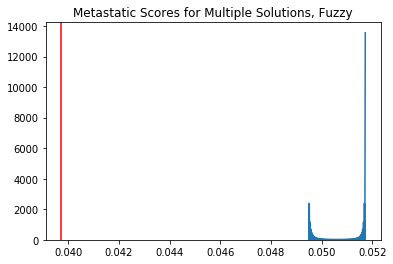

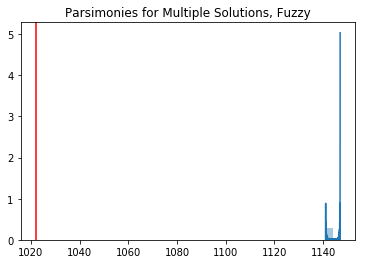

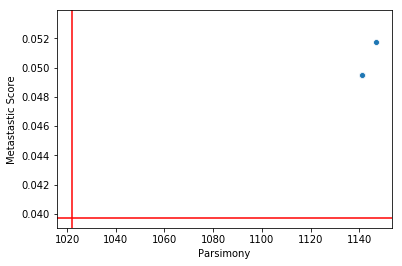

In [28]:
sns.kdeplot(met_scores, shade=True);
plt.axvline(x = main_met_score, color='red')
plt.title('Metastatic Scores for Multiple Solutions, Fuzzy')
plt.show()

sns.distplot(pars)
plt.axvline(x = main_pars, color='red')
plt.title('Parsimonies for Multiple Solutions, Fuzzy')
plt.show()

sns.scatterplot(pars, met_scores)
plt.xlabel('Parsimony')
plt.ylabel('Metastastic Score')
plt.axhline(y = main_met_score, color='red')
plt.axvline(x = main_pars, color='red')

In [10]:
met_scores = []
pars = []
for a in tqdm(lg19.alternative_solutions):
    
    t = Cassiopeia_Tree('hybrid', network=a, character_matrix = cm)
    pars.append(t.score_parsimony())
    
    # p = ppt.post_process_tree(a, cm, 'hybrid')
    p = t.post_process(cm).network
    met_scores.append(met_utils.compute_dynamic_metastasis_score(p, meta['sampleID']))
    
    assert(len([n for n in p if n.is_target]) == 323)
    
    if met_scores[-1] < 0.039:
        print('here')
        pic.dump(p, open('lg19_lowmetscore_altsoln.pkl', 'wb'))
        with open('lg19_lowmetscore_altsoln.txt', 'w') as f:
            f.write(data_pipeline.convert_network_to_newick_format(p))

 77%|███████▋  | 77/100 [00:58<00:18,  1.27it/s]

here


100%|██████████| 100/100 [01:15<00:00,  1.35it/s]


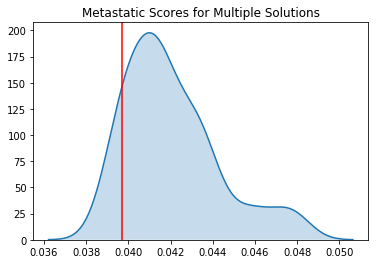

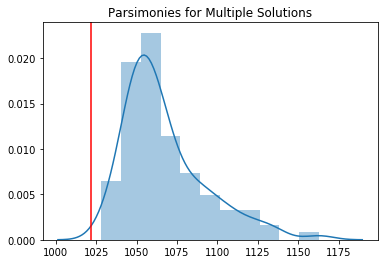

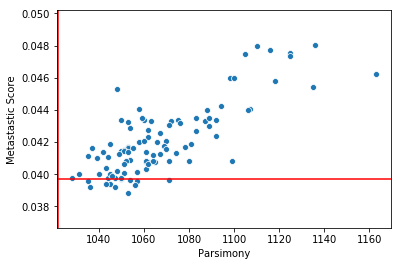

In [9]:
sns.kdeplot(met_scores, shade=True);
plt.axvline(x = main_met_score, color='red')
plt.title('Metastatic Scores for Multiple Solutions')
plt.show()

sns.distplot(pars)
plt.axvline(x = main_pars, color='red')
plt.title('Parsimonies for Multiple Solutions')
plt.show()

sns.scatterplot(pars, met_scores)
plt.xlabel('Parsimony')
plt.ylabel('Metastastic Score')
plt.axhline(y = main_met_score, color='red')
plt.axvline(x = main_pars, color='red')